In [257]:
from pandas import Series 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve, plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore") 



In [258]:
# Функция для вывода метрик для оценки качества модели
def all_metrics(y_true, y_pred, y_pred_prob):
    dict_metric = {}
    P = np.sum(y_true==1)
    N = np.sum(y_true==0)
    TP = np.sum((y_true==1)&(y_pred==1))
    TN = np.sum((y_true==0)&(y_pred==0))
    FP = np.sum((y_true==0)&(y_pred==1))
    FN = np.sum((y_true==1)&(y_pred==0))
    
    dict_metric['Positive, P'] = [P,'default']
    dict_metric['Negative, N'] = [N,'non-default']
    dict_metric['True Positive, TP'] = [TP,'correctly identified default']
    dict_metric['True Negative, TN'] = [TN,'correctly identified non-default']
    dict_metric['False Positive, FP'] = [FP,'incorrectly identified default']
    dict_metric['False Negative, FN'] = [FN,'incorrectly identified non-default']
    dict_metric['Accuracy'] = [accuracy_score(y_true, y_pred),'Accuracy=(TP+TN)/(P+N)']
    dict_metric['Precision'] = [precision_score(y_true, y_pred),'Precision = TP/(TP+FP)'] 
    dict_metric['Recall'] = [recall_score(y_true, y_pred),'Recall = TP/P']
    dict_metric['F1-score'] = [f1_score(y_true, y_pred),'Harmonical mean of Precision и Recall']
    dict_metric['ROC_AUC'] = [roc_auc_score(y_true, y_pred_prob),'ROC AUC Score']    

    temp_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=['Value', 'Description'])
    display(temp_df) 

In [259]:
train = pd.read_csv('scor_train.csv')
test= pd.read_csv('scor_test.csv')
sample_submission = pd.read_csv('scor_sample_submission.csv')



Подробнее по признакам:

    client_id - идентификатор клиента
    education - уровень образования
    sex - пол заемщика
    age - возраст заемщика
    car - флаг наличия автомобиля
    car_type - флаг автомобиля иномарки
    decline_app_cnt - количество отказанных прошлых заявок
    good_work - флаг наличия “хорошей” работы
    bki_request_cnt - количество запросов в БКИ
    home_address - категоризатор домашнего адреса
    work_address - категоризатор рабочего адреса
    income - доход заемщика
    foreign_passport - наличие загранпаспорта
    sna - связь заемщика с клиентами банка
    first_time - давность наличия информации о заемщике
    score_bki - скоринговый балл по данным из БКИ
    region_rating - рейтинг региона
    app_date - дата подачи заявки
    default - флаг дефолта по кредиту



In [260]:
train.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
55114,17045,24JAN2014,SCH,F,49,N,N,0,0,-1.974156,4,80,2,3,13000,2,1,N,0
36901,60585,10MAR2014,SCH,M,49,N,N,1,0,-1.988769,0,60,1,2,30000,1,3,N,0
49387,11074,18JAN2014,GRD,M,30,N,N,0,0,-1.796679,2,40,2,3,35000,1,3,N,1
30168,43922,20FEB2014,SCH,F,51,N,N,0,0,-1.851441,1,50,3,3,22000,1,4,Y,0
39080,30436,06FEB2014,UGR,F,38,Y,Y,0,1,-2.440301,5,70,1,3,163000,1,3,Y,0


In [261]:
test.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
23159,97196,14APR2014,UGR,M,31,N,N,0,1,-1.239173,0,80,2,3,60000,1,3,N
16809,36683,12FEB2014,GRD,F,27,Y,Y,0,0,-2.389612,2,50,1,1,60000,1,3,N
7315,87880,04APR2014,UGR,M,31,Y,Y,0,0,-2.089350,3,40,1,2,60000,2,2,N
17711,103522,22APR2014,UGR,F,55,Y,N,0,1,-1.815427,7,50,2,3,25000,1,3,N
26355,81262,29MAR2014,GRD,M,42,N,N,0,0,-1.965302,4,60,2,3,39000,1,3,N


In [262]:
train.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,0.126994
std,31841.921168,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000
max,110147.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000


In [263]:
test.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time
count,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000
mean,54945.647473,39.186002,0.268040,0.166772,-1.904152,2.014471,56.802938,1.573798,2.501087,40835.755729,1.728053,2.765798
std,31706.052195,11.513258,0.788478,0.372777,0.501764,2.296789,13.086646,0.527428,0.683227,43802.180951,1.120686,1.011560
min,4.000000,21.000000,0.000000,0.000000,-3.574197,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000
25%,27744.000000,30.000000,0.000000,0.000000,-2.261909,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000
50%,54657.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000
75%,82322.000000,48.000000,0.000000,0.000000,-1.563957,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000
max,110148.000000,71.000000,30.000000,1.000000,0.188820,47.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000


# Предобработка данных¶

In [264]:
# Посмотрим на рапределение целевой переменной
train.default.value_counts()

0    64427
1     9372
Name: default, dtype: int64

<AxesSubplot:xlabel='default', ylabel='count'>

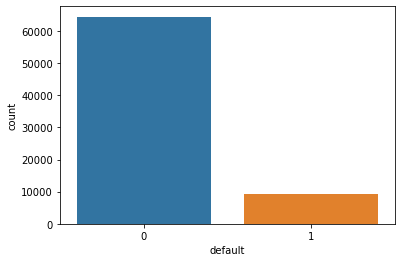

In [265]:
sns.countplot(x='default', data=train)

In [266]:
# Количество пропусков в обучающей базе
train.isna().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [267]:
# Количество пропусков в тестовой базе
test.isna().sum()

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

In [268]:
# Заполняем пропуски в образовании наиболее часто втсречающимся значением
train['education'].fillna(train['education'].mode, inplace=True)
test['education'].fillna(test['education'].mode, inplace=True)

In [269]:
# Выведем наименования всех признаков обучающей базы
train.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

In [270]:
#Разбиваем признаки на 3 списка (искл. client_id, app_date)

num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating']

# категориальные
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time']

# бинарные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# Числовые признаки

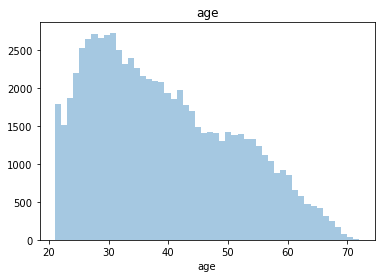

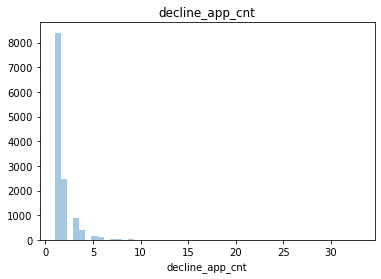

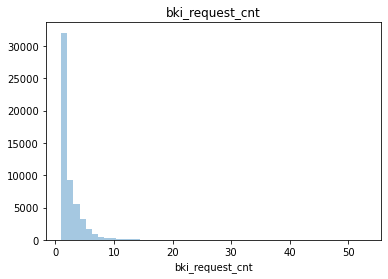

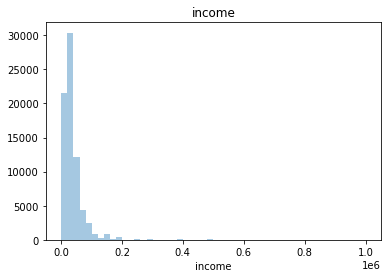

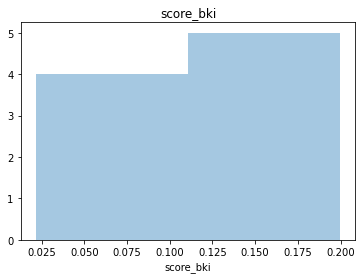

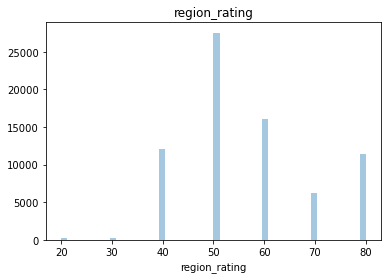

In [271]:
# Графики распределений числовых признаков
for i in num_cols:
    plt.figure()
    sns.distplot(train[i][train[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

В блоке Feature Engineering прологарифмируем численные переменные, распределение которых смещено.

<AxesSubplot:>

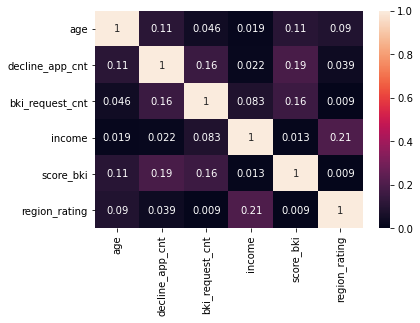

In [272]:
# Посмотрим на тепловую карту числовых признаков
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1, annot = True)

Очевидно, что все выбранные признаки слабо коррелируют друг с другом.

<AxesSubplot:>

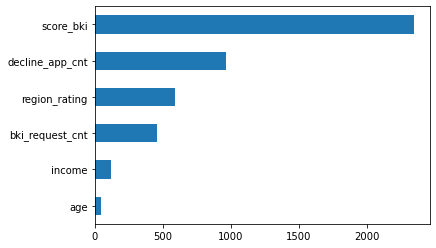

In [273]:
# Посмотрим значимость числовых признаков
imp_num = pd.Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

# Бинарные и категориальные признаки

In [274]:
# Для бинарных признаков мы будем использовать LabelEncoder, чтобы избавится от строковых значений

label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    
for column in bin_cols:
    test[column] = label_encoder.fit_transform(test[column])

In [275]:
# Заменим значения признака education числами в обучающей базе
train.education = pd.Categorical(train.education)
train['education'] = train['education'].cat.codes

In [276]:
# посмотрим как выглядит обучающая база после изменений
train.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
55752,89752,06APR2014,4,0,55,0,0,0,0,-1.694850,10,40,2,3,26000,4,1,0,0
68012,99166,16APR2014,2,1,56,1,0,0,0,-2.353052,0,40,2,3,40000,1,4,0,0
6553,9375,16JAN2014,4,1,39,0,0,0,0,-1.776422,1,80,2,3,81000,1,1,1,0
61001,32834,09FEB2014,2,0,54,0,0,0,1,-2.051345,3,50,1,1,9000,1,3,0,0
60714,26471,02FEB2014,4,0,59,1,1,0,0,-1.686698,3,50,1,2,55000,1,3,0,0


In [277]:
train.education.value_counts()

4    38860
2    23365
5     9816
3     1257
0      307
1      194
Name: education, dtype: int64

In [278]:
# Сделаем тоже самое для тестовой базы
test.education = pd.Categorical(test.education)
test['education'] = test['education'].cat.codes

In [279]:
test.education.value_counts()

4    19138
2    11403
5     4932
3      608
0      171
1       97
Name: education, dtype: int64

# Немного поработает с датами

In [280]:
# Переведем даты из признака app_date к типу datetime 
train.app_date = pd.to_datetime(train.app_date)
test.app_date = pd.to_datetime(test.app_date)

In [281]:
# Посмотрим количество уникальных годов в признаке app_date обучающей базы
train.app_date.apply(lambda x: x.year).value_counts()

2014    73799
Name: app_date, dtype: int64

In [282]:
# Посмотрим количество уникальных годов в признаке app_date тестовой базы
test.app_date.apply(lambda x: x.year).value_counts()

2014    36349
Name: app_date, dtype: int64

In [283]:
# Посмотрим количество уникальных месяцев в признаке app_date обучающей базы
train.app_date.apply(lambda x: x.month).value_counts()

3    21178
2    18028
4    17683
1    16910
Name: app_date, dtype: int64

In [284]:
# Посмотрим количество уникальных месяцев в признаке app_date тестовой базы
test.app_date.apply(lambda x: x.month).value_counts()

3    10419
2     9069
4     8583
1     8278
Name: app_date, dtype: int64

# Добавление новых признаков (Feature engineering)

In [285]:
# Новый признак месяца подачи заявления на кредит
train['month'] = train.app_date.apply(lambda x: x.month)
test['month'] = train.app_date.apply(lambda x: x.month)

cat_cols.append('month')

In [286]:
# Новый признак количество дней между датой подачи заявления на кредит и датой первой подачи в базе
train['days'] = (train.app_date - train.app_date.min()).dt.days
test['days'] = (test.app_date - test.app_date.min()).dt.days

num_cols.append('days')

# Попробуем перевести часть признаков из числовых в категориальные

In [287]:
#Посмотрим на распределение значений decline_app_cnt в обучающей выборке
train.decline_app_cnt.value_counts()

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
24        1
15        1
19        1
22        1
33        1
Name: decline_app_cnt, dtype: int64

In [288]:
# изменим значения признака decline_app_cnt, которые встречаются наиболее редко, единственным значением
train['decline_app_cnt'] = train['decline_app_cnt'].apply(lambda x: 4 if x > 4 else x)
test['decline_app_cnt'] = test['decline_app_cnt'].apply(lambda x: 4 if x > 4 else x)

In [289]:
train.decline_app_cnt.value_counts()

0    61214
1     8397
2     2468
3      903
4      817
Name: decline_app_cnt, dtype: int64

In [290]:
# тоже самое проделаем с признаком bki_request_cnt
train.bki_request_cnt.value_counts()

0     19381
1     18276
2     13749
3      9187
4      5627
5      3268
6      1704
7       852
8       508
9       299
10      225
11      188
12      144
13       94
14       86
15       54
16       35
18       22
17       19
19       18
21       12
24       11
20        9
23        7
28        4
22        4
32        2
27        2
26        2
25        2
46        1
29        1
33        1
34        1
36        1
41        1
45        1
53        1
Name: bki_request_cnt, dtype: int64

In [291]:
train['bki_request_cnt'] = train['bki_request_cnt'].apply(lambda x: 6 if x > 6 else x)
test['bki_request_cnt'] = test['bki_request_cnt'].apply(lambda x: 6 if x > 6 else x)

In [292]:
train.bki_request_cnt.value_counts()

0    19381
1    18276
2    13749
3     9187
4     5627
6     4311
5     3268
Name: bki_request_cnt, dtype: int64

In [293]:
num_cols.remove('decline_app_cnt')
cat_cols.append('decline_app_cnt')

In [294]:
num_cols.remove('bki_request_cnt')
cat_cols.append('bki_request_cnt')

In [295]:
#логорифмируем числовые признаки
num_cols_log = ['age', 'income']

for i in num_cols_log:
    train[i] = np.log(train[i] + 1)
    
    
for i in num_cols_log:
    test[i] = np.log(test[i] + 1)

# Визуализация и значимость признаков

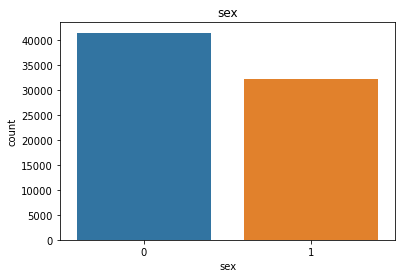

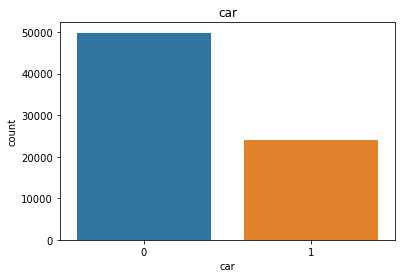

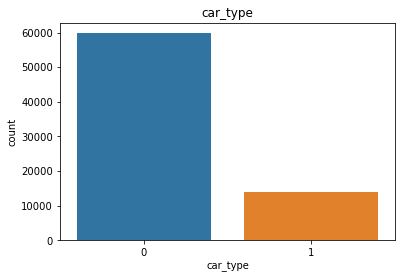

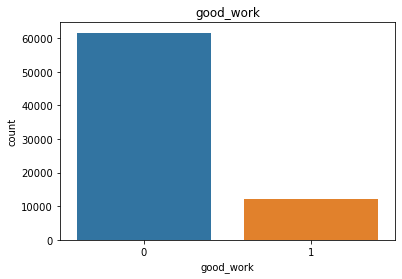

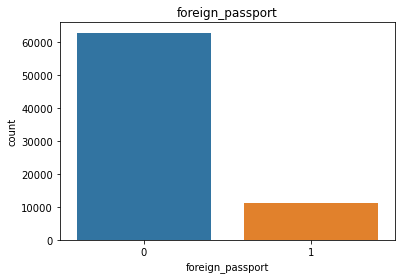

In [296]:
# Посмотрим на диаграмму распределения бинарных признаков
for column in bin_cols:
    plt.figure()
    sns.countplot(train[column])
    plt.title(column)
    plt.show()

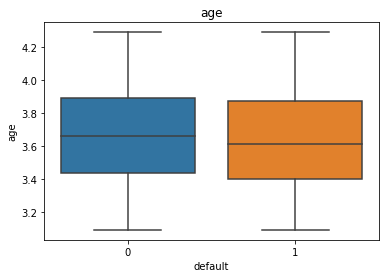

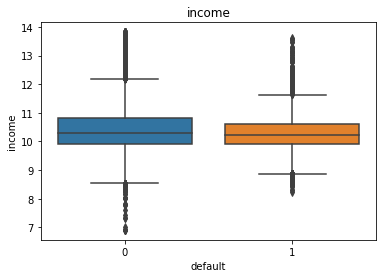

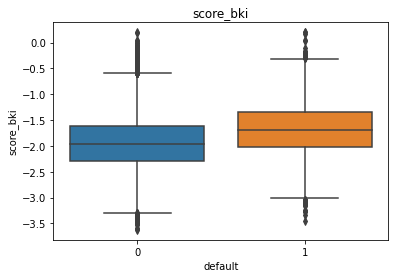

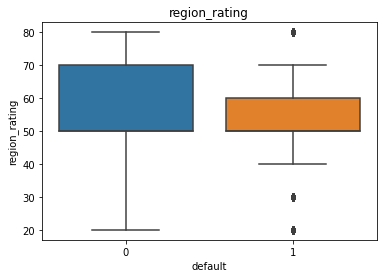

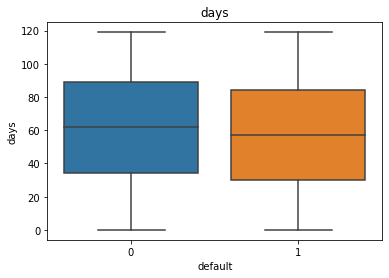

In [297]:
# boxplots числовых признаков
for column in num_cols:
    plt.figure()
    sns.boxplot(x=train['default'], y=train[column])
    plt.title(column)
    plt.show()

<AxesSubplot:>

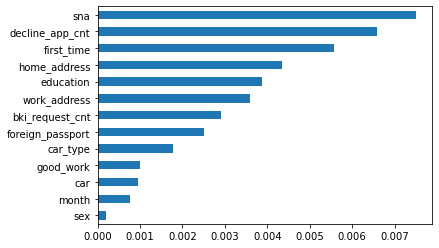

In [298]:
# Значимость бинарных и категориальных переменных
imp_cat = Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Text(0.5, 0, 'F-value')

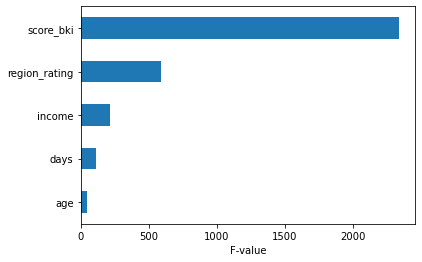

In [299]:
# еще раз посмотрим на значимость числовых переменных
imp_num = Series(f_classif(train[num_cols], train['default'])[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.xlabel('F-value')

In [300]:
# посмотрим на корреляцию признаков обучающей базы
corr_train = train.drop(['client_id', 'education'],axis = 1).corr()
corr_train.style.background_gradient(cmap='RdYlBu').set_precision(3)

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,month,days
sex,1.000,-0.127,0.279,0.226,0.023,-0.040,-0.045,-0.049,0.108,0.038,0.069,0.305,-0.004,0.014,0.086,0.020,-0.030,-0.033
age,-0.127,1.000,-0.037,-0.034,-0.125,-0.073,-0.110,0.055,-0.091,0.000,-0.015,-0.093,-0.070,0.095,-0.037,-0.026,0.015,0.017
car,0.279,-0.037,1.000,0.698,-0.036,0.002,-0.045,-0.043,0.065,-0.025,-0.008,0.325,-0.072,0.090,0.108,-0.043,-0.020,-0.022
car_type,0.226,-0.034,0.698,1.000,-0.048,0.018,-0.040,-0.010,0.104,-0.012,0.001,0.370,-0.086,0.104,0.146,-0.057,-0.025,-0.027
decline_app_cnt,0.023,-0.125,-0.036,-0.048,1.000,-0.030,0.203,0.126,-0.040,0.011,0.017,-0.013,0.069,-0.074,-0.030,0.121,-0.022,-0.023
good_work,-0.040,-0.073,0.002,0.018,-0.030,1.000,0.006,0.006,0.073,-0.004,-0.009,0.052,-0.054,0.056,0.046,-0.043,0.005,0.005
score_bki,-0.045,-0.110,-0.045,-0.040,0.203,0.006,1.000,0.145,0.009,0.014,0.013,0.003,0.068,-0.069,-0.022,0.175,-0.062,-0.064
bki_request_cnt,-0.049,0.055,-0.043,-0.010,0.126,0.006,0.145,1.000,-0.005,0.005,0.001,0.090,0.007,0.014,0.001,0.076,-0.020,-0.019
region_rating,0.108,-0.091,0.065,0.104,-0.040,0.073,0.009,-0.005,1.000,0.234,0.254,0.313,-0.078,0.089,0.255,-0.089,0.005,0.007
home_address,0.038,0.000,-0.025,-0.012,0.011,-0.004,0.014,0.005,0.234,1.000,0.728,0.047,0.115,-0.058,0.039,0.085,0.169,0.164


In [301]:
# Признаки с высокой корреляцией (по модулю больше 0.8) удалим
cat_cols.remove('month')

# Подготовка модели

In [302]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
X_cat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [303]:
Y_cat = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)
Y_cat

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [304]:
# Стандартизация числовых непрерывных переменных на обучающей базе

X_num = StandardScaler().fit_transform(train[num_cols].values)
X_num

array([[ 1.71113664, -0.78501579, -0.2087987 , -0.51515718, -0.93505217],
       [ 1.5399884 , -0.70752611,  0.74754461, -0.51515718,  0.27908159],
       [-1.39343857, -0.05288771,  0.99669566,  1.78270228, -0.93505217],
       ...,
       [-0.66507223,  0.5282444 ,  0.78696739,  1.78270228,  1.55547863],
       [-0.89146325, -1.25140899,  0.85380611, -0.51515718, -1.80673795],
       [-0.35072683, -0.31419734,  0.28102087, -0.51515718, -1.21523689]])

In [305]:
# Стандартизация числовых непрерывных переменных на тестовой базе

Y_num = StandardScaler().fit_transform(test[num_cols].values)
Y_num

array([[-0.88333898,  0.68282058, -0.73288746, -0.51984533,  0.59902814],
       [ 0.12606863, -2.63253397,  0.79551047, -0.51984533, -1.18319733],
       [ 0.97850869, -0.05272498,  0.42413578, -0.51984533,  0.63029526],
       ...,
       [-0.65688874,  0.9453502 ,  1.92005304, -0.51984533,  0.84916505],
       [-1.12541848, -0.05272498,  1.31888606,  1.77259941, -1.71473827],
       [ 0.0372345 , -1.05077617,  0.79042787, -0.51984533,  0.44269258]])

In [306]:
# Объединяем

X = np.hstack([X_num, train[bin_cols].values, X_cat])
Y = train['default'].values

id_test = test['client_id']
test = np.hstack([Y_num, test[bin_cols].values, Y_cat])

In [307]:
# Разделяем обучающую выборку на тренировочную и валидационную
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle = True)

In [308]:
# Подбор лучших гиперпараметров для модели

from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
С = best_model.best_estimator_.get_params()['C']

Лучшее Penalty: l2
Лучшее C: 7.742636826811269


In [311]:
# Описываем и обучаем модель
model = LogisticRegression( 
                           C=best_model.best_estimator_.get_params()['C'], 
                           class_weight='balanced', 
                           dual=False, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           l1_ratio=None, 
                           multi_class='auto', 
                           n_jobs=None, 
                           penalty='l2', 
                           solver='liblinear', 
                           verbose=0, 
                           max_iter=1000)

model.fit(X_train, y_train)

LogisticRegression(C=7.742636826811269, class_weight='balanced', max_iter=1000,
                   solver='liblinear')

In [312]:
# Предсказываем значения валидационной базы
Y_predict = model.predict(X_valid)
Y_predict_prob = model.predict_proba(X_valid)[:,1]

In [313]:
# Предсказываем значения тестовой базы
y_pred_test = model.predict(test)
y_pred_prob_test = model.predict_proba(test)[:,1]

# Предварительные результаты

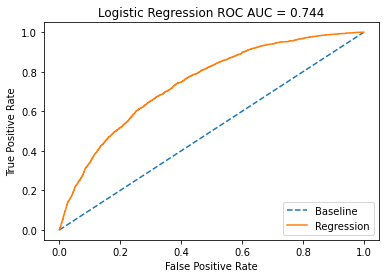

In [314]:
# Строим ROC-кривую
fpr, tpr, threshold = roc_curve(y_valid, Y_predict_prob)
roc_auc = roc_auc_score(y_valid, Y_predict_prob)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [315]:
#считаем confusion_matrix ...
cm=confusion_matrix(y_valid,Y_predict)
cm

array([[8644, 4289],
       [ 578, 1249]], dtype=int64)

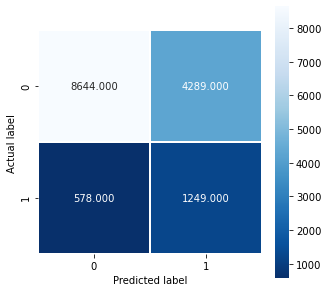

In [321]:
# визуализируем для наглядности
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');


In [317]:
# Выведем метрики качества модели
all_metrics(y_valid, Y_predict, Y_predict_prob)

,Value,Description
"Positive, P",1827.000000,default
"Negative, N",12933.000000,non-default
"True Positive, TP",1249.000000,correctly identified default
"True Negative, TN",8644.000000,correctly identified non-default
"False Positive, FP",4289.000000,incorrectly identified default
"False Negative, FN",578.000000,incorrectly identified non-default
Accuracy,0.670257,Accuracy=(TP+TN)/(P+N)
Precision,0.225533,Precision = TP/(TP+FP)
Recall,0.683634,Recall = TP/P
F1-score,0.339172,Harmonical mean of Precision и Recall


In [318]:
# Обучаем модель на всей обучающей базе
main_model = LogisticRegression( 
                           C=best_model.best_estimator_.get_params()['C'], 
                           class_weight='balanced', 
                           dual=False, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           l1_ratio=None, 
                           multi_class='auto', 
                           n_jobs=None, 
                           penalty='l2', 
                           solver='liblinear', 
                           verbose=0, 
                           max_iter=1000)
main_model.fit(X, Y)

# Предсказываем значения тестовой базы
y_pred_test = main_model.predict(test)
y_pred_prob_test = main_model.predict_proba(test)[:,1]

In [320]:
# Записываем предсказанные моделью вероятности дефолта заемщиков из тестовой базы в отдельный файл
new_sample_submission = pd.DataFrame({'client_id': id_test,
                              'default': y_pred_prob_test})
new_sample_submission.to_csv('submission.csv', index=False)

new_sample_submission.head(10)

,client_id,default
0,74835,0.207307
1,17527,0.776586
2,75683,0.313044
3,26883,0.417367
4,28862,0.144265
5,99881,0.577936
6,26630,0.790445
7,79934,0.168988
8,16605,0.144032
9,105449,0.150455
